In [62]:
!pip install fastai
!pip install timm

In [63]:
from fastai.vision.all import *
import timm

In [64]:
path = Path('./scene_classification_clean/data/')

In [65]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(150)],
        batch_tfms=aug_transforms(mult=1.5, size=150, min_scale=0.75))

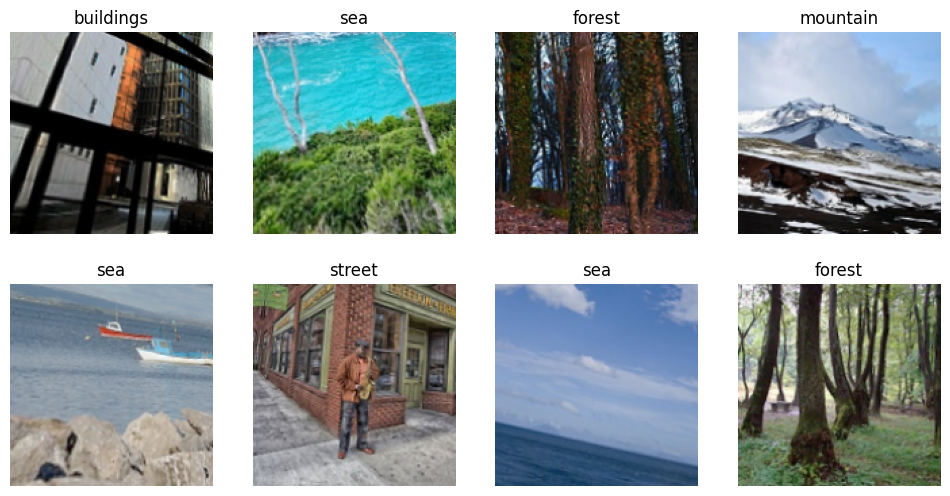

In [66]:
loaders = block.dataloaders(path)
loaders.train.show_batch(max_n=8, nrows=2)

In [67]:

timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [68]:
learn = vision_learner(loaders, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0006918309954926372)

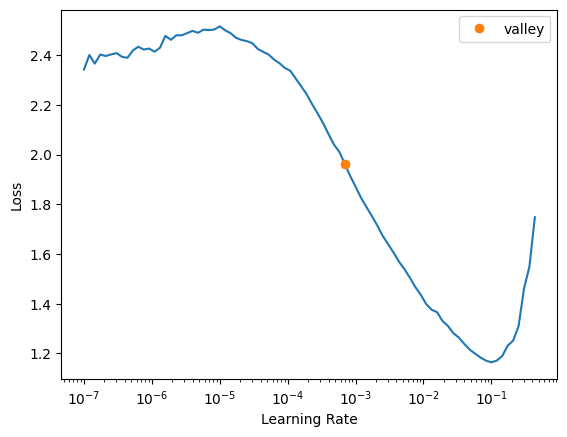

In [69]:
learn.lr_find()

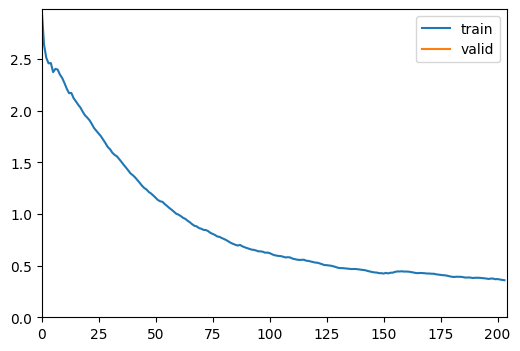

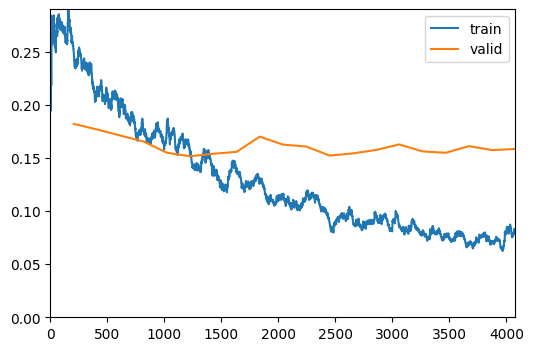

In [70]:
learn.fine_tune(20, base_lr=1e-3, cbs=[ShowGraphCallback()])

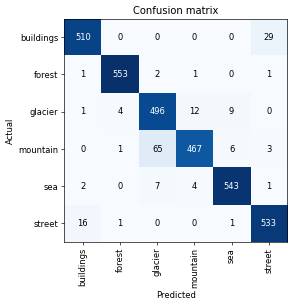

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

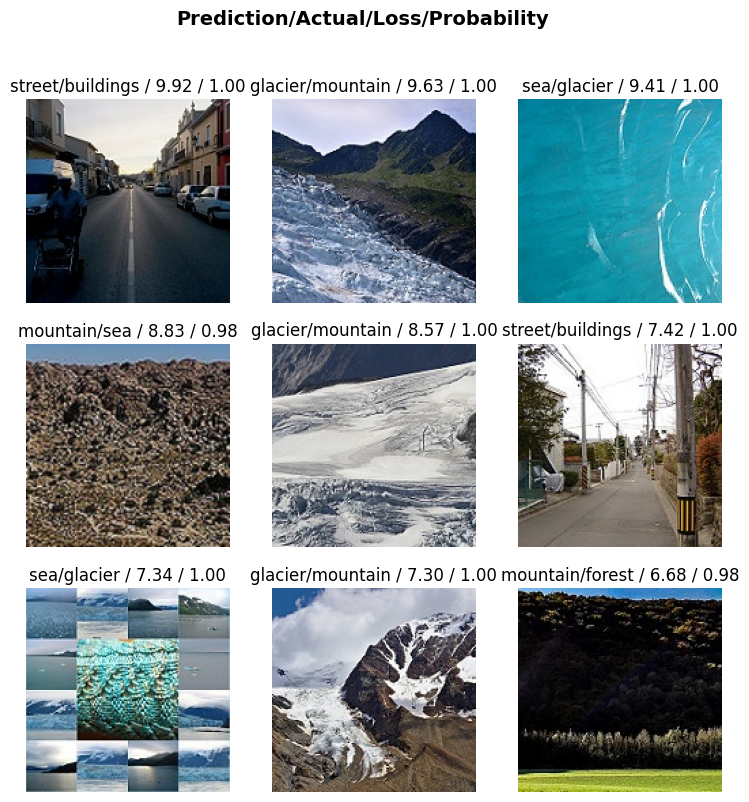

In [72]:
interp.plot_top_losses(9)

In [73]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn, height=256)
cleaner

In [74]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [75]:
interp.most_confused

[('mountain', 'glacier', 65),
 ('buildings', 'street', 29),
 ('street', 'buildings', 16),
 ('glacier', 'mountain', 12),
 ('glacier', 'sea', 9),
 ('sea', 'glacier', 7),
 ('mountain', 'sea', 6)]

glacier   64.14% confidence.   Image = 5115.jpg
forest   99.71% confidence.   Image = 7792.jpg
glacier   100.00% confidence.   Image = 2992.jpg
buildings   99.46% confidence.   Image = 8753.jpg
forest   99.96% confidence.   Image = 12964.jpg
mountain   50.25% confidence.   Image = 2622.jpg
street   99.98% confidence.   Image = 14084.jpg
sea   97.62% confidence.   Image = 22880.jpg
forest   99.97% confidence.   Image = 16780.jpg
forest   100.00% confidence.   Image = 8133.jpg
buildings   99.53% confidence.   Image = 6581.jpg
glacier   99.99% confidence.   Image = 8017.jpg
sea   100.00% confidence.   Image = 4395.jpg
buildings   62.52% confidence.   Image = 19731.jpg
forest   99.96% confidence.   Image = 5015.jpg
forest   100.00% confidence.   Image = 9226.jpg
mountain   89.17% confidence.   Image = 13529.jpg
street   99.98% confidence.   Image = 17084.jpg
forest   99.98% confidence.   Image = 6039.jpg
forest   100.00% confidence.   Image = 24148.jpg


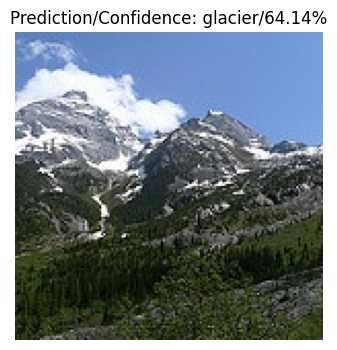

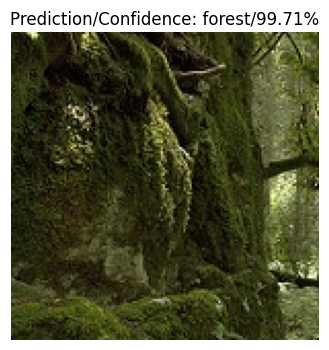

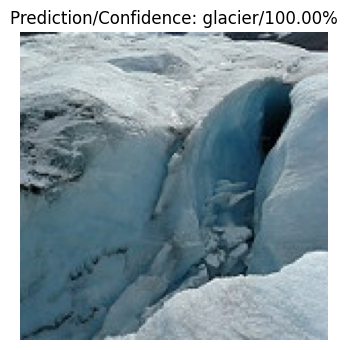

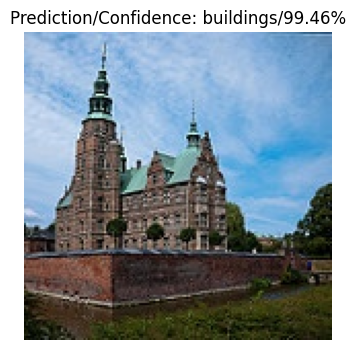

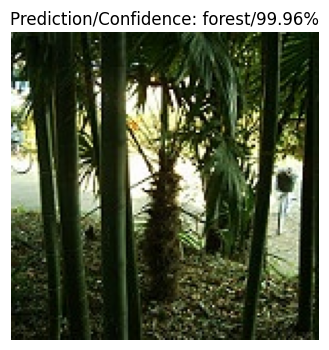

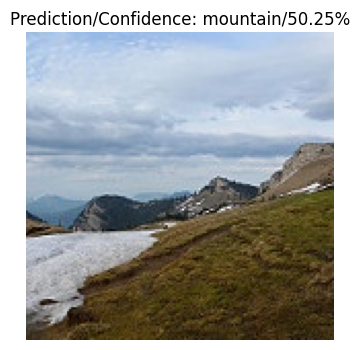

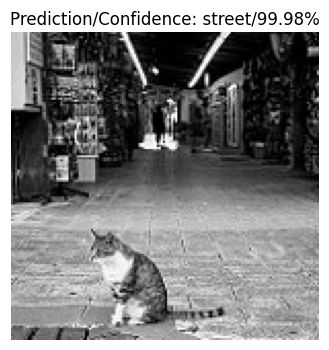

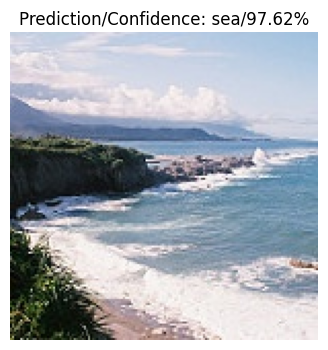

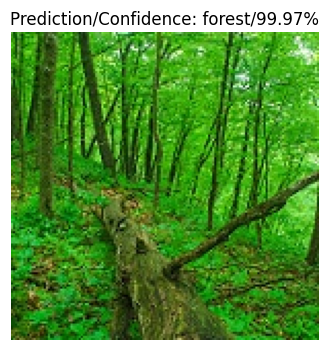

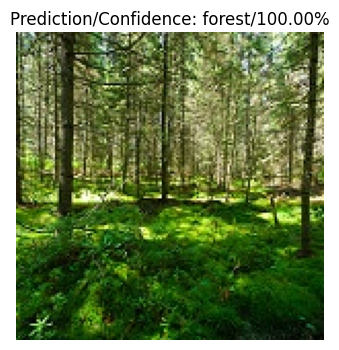

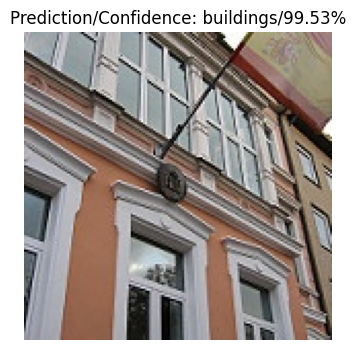

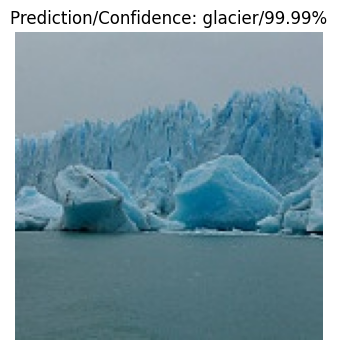

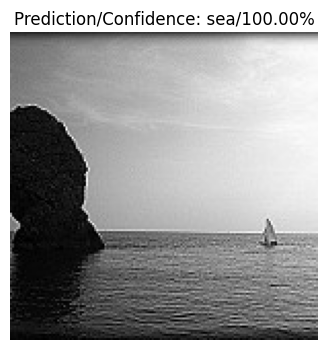

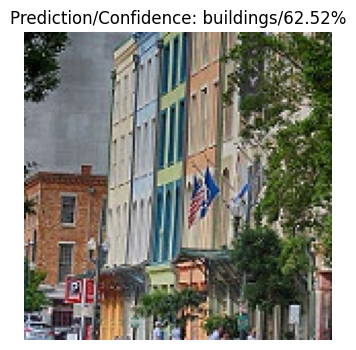

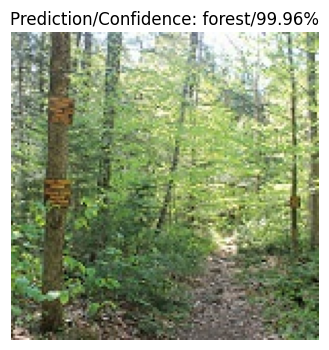

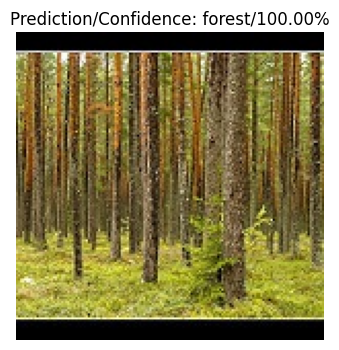

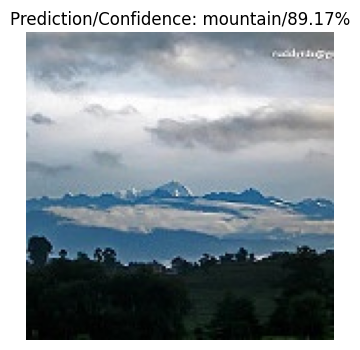

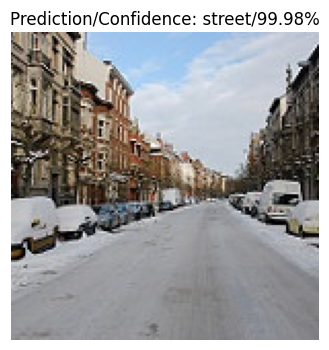

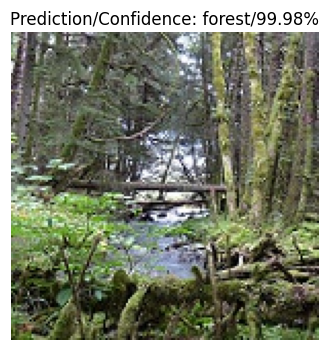

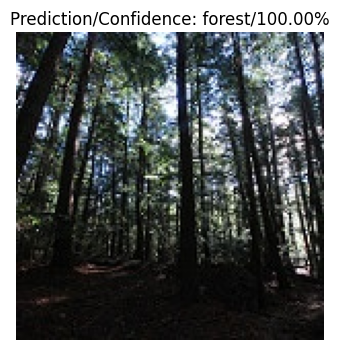

In [76]:
test_dl = learn.dls.test_dl(get_image_files('scene_classification/data/test_set/'))
preds = learn.get_preds(dl=test_dl)
num_images_to_show = 20
for index,item in enumerate(preds[0]):
    if index == num_images_to_show:
        break
    prediction = learn.dls.categorize.decode(np.argmax(item))
    confidence = max(item)
    percent = float(confidence)
    print(f"{prediction}   {percent*100:.2f}% confidence.   Image = {test_dl.items[index].name}")
    im = PILImage.create(test_dl.items[index])
    im.thumbnail((150,150))
    im.show(title=f'Prediction/Confidence: {prediction}/{percent*100:.2f}%')

    